# Flag Predictor - Visualization Notebook

This notebook provides visualization tools for the Flag Predictor system.
All computation is handled by the `flag_predictor` package.

## Quick Start
1. Set `LOCATION` to either 'isis', 'godstow', or 'wallingford'
2. Run all cells to generate forecast and visualizations

**Note:** Each location uses different rainfall stations:
- **ISIS**: 13 default stations
- **Godstow**: 11 stations (excludes Bicester and Grimsbury)
- **Wallingford**: 19 stations (all default + 6 Wallingford-specific stations)

In [27]:
# Standard imports
import sys
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
from tqdm import tqdm
import importlib

# Add src to path for development
sys.path.insert(0, os.path.abspath('../src'))

# Force reload of flag_predictor modules (in case they were modified)
import flag_predictor
import flag_predictor.data.api
import flag_predictor.config
importlib.reload(flag_predictor.data.api)
importlib.reload(flag_predictor.config)
importlib.reload(flag_predictor)

# Flag Predictor imports
from flag_predictor import get_location_config
from flag_predictor.pipeline import prepare_training_data
from flag_predictor.models import load_model
from flag_predictor.prediction import predict_ensemble
from flag_predictor.data.api import get_rainfall_forecast_ensemble
from flag_predictor.config import (
    RAINFALL_STATION_NAMES, 
    WALLINGFORD_RAINFALL_STATION_NAMES,
    FLAG_COLORS,
    get_flag_thresholds  # Use location-specific thresholds
)

def get_location_station_names(location: str) -> list:
    """
    Get the correct rainfall station names for a given location.
    
    - ISIS: All default stations (13 stations)
    - Godstow: Default stations EXCEPT Bicester and Grimsbury (11 stations)
    - Wallingford: All default stations PLUS Wallingford-specific stations (19 stations)
    """
    location_lower = location.lower()
    
    if location_lower == 'wallingford':
        # Wallingford: all default + Wallingford-specific
        return list(RAINFALL_STATION_NAMES) + list(WALLINGFORD_RAINFALL_STATION_NAMES)
    elif location_lower == 'godstow':
        # Godstow: exclude Bicester and Grimsbury
        return [s for s in RAINFALL_STATION_NAMES if s not in {'Bicester', 'Grimsbury'}]
    else:
        # ISIS (or other): all default stations
        return list(RAINFALL_STATION_NAMES)

# Plot settings
plt.rcParams['figure.figsize'] = (18, 10)
plt.rcParams['font.size'] = 11

print("✓ Imports complete")

✓ Imports complete


## Configuration and Load Data

Select the location to analyze:

In [28]:
# ===== CONFIGURATION =====
# Choose location: 'isis' or 'godstow' or 'wallingford'
LOCATION = 'wallingford'
# =========================

config = get_location_config(LOCATION)
print(f"\nLocation: {config.display_name}")
print(f"Horizons: {len(config.horizons)} prediction points")
print(f"Max horizon: {max(config.horizons)} hours ({max(config.horizons)//24} days)")

# Load location-specific flag thresholds
FLAG_THRESHOLDS = get_flag_thresholds(LOCATION)
# Skip displaying thresholds for Wallingford (sensitive information)
if LOCATION.lower() != 'wallingford':
    print(f"\nFlag thresholds for {LOCATION}:")
    for flag, (lower, upper) in FLAG_THRESHOLDS.items():
        print(f"  {flag}: {lower:.3f} - {upper:.3f}")
else:
    print(f"\nFlag thresholds for {LOCATION}: Not displayed (white flags - no flags)")


Location: Wallingford Stretch
Horizons: 24 prediction points
Max horizon: 240 hours (10 days)

Flag thresholds for wallingford:
  green: -inf - 1.500
  light_blue: 1.500 - 1.500
  dark_blue: 1.500 - 1.500
  amber: 1.500 - 1.500
  red: 1.500 - inf


In [29]:
# Prepare historical data
merged_df, X, y_multi = prepare_training_data(
    location=LOCATION,
    project_root=os.path.abspath('..'),
    verbose=True
)


Preparing training data for Wallingford Stretch
✓ Loaded Wallingford Stretch historical data: (191307, 1)
  Date range: 2020-02-13 20:30:00+00:00 to 2026-01-20 10:00:00+00:00
Loading historical rainfall data from 19 files...

✓ Combined historical rainfall: (314534, 19)
  Date range: 2017-02-02 00:00:00 to 2026-01-22 09:00:00
Fetching river level data...
  ✓ kings_mill_downstream: 2850 records
  ✓ godstow_downstream: 2851 records
  ✓ osney_upstream: 2851 records
  ✓ osney_downstream: 2850 records
  ✓ iffley_upstream: 2851 records
  ✓ benson_downstream: 2851 records
  ✓ cleeve_upstream: 2851 records
Fetching rainfall data...
  Including 6 Wallingford-specific stations
  ✓ Osney: 2851 records
  ✓ Eynsham: 2851 records
  ✓ St: 2202 records
  ✓ Shorncote: 2851 records
  ✓ Rapsgate: 2851 records
  ✓ Stowell: 2851 records
  ✓ Bourton: 2851 records
  ✓ Chipping: 2850 records
  ✓ Grimsbury: 2851 records
  ✓ Bicester: 2851 records
  ✓ Byfield: 2844 records
  ✓ Swindon: 2851 records
  ✓ Worsham

## Load Model

In [30]:
# Choose which saved model to use
# - Set USE_EXPERIMENT_MODEL = True to use the 2026_01 experiment snapshot
# - Leave as False to  the location-specific "latest" snapshot
USE_EXPERIMENT_MODEL = True

if USE_EXPERIMENT_MODEL:
    # Expect location-specific experiment files, e.g.
    #   multihorizon_model_experiment_2026_01_isis.pth
    #   scaler_experiment_2026_01_isis.pkl
    #   config_experiment_2026_01_isis.pkl
    # for LOCATION='isis', and similarly for 'godstow', etc.
    model, scaler, model_config = load_model(
        model_path=f"../models/multihorizon_model_experiment_2026_01_{LOCATION}.pth",
        scaler_path=f"../models/scaler_experiment_2026_01_{LOCATION}.pkl",
        config_path=f"../models/config_experiment_2026_01_{LOCATION}.pkl",
    )
else:
    # Use location-specific latest files (e.g. 2025_08 model for ISIS)
    model, scaler, model_config = load_model(
        models_dir="../models",
        location=LOCATION,
    )

print(f"\nModel configuration:")
print(f"  Sequence length: {model_config['sequence_length']}")
print(f"  Hidden sizes: {model_config['hidden_sizes']}")
print(f"  Features: {len(model_config['feature_columns'])}")

Using device: mps (Apple Silicon GPU)
✓ Model loaded from: ../models/multihorizon_model_experiment_2026_01_wallingford.pth
✓ Scaler loaded from: ../models/scaler_experiment_2026_01_wallingford.pkl
✓ Sequence length: 100
✓ Horizons: [2, 4, 6, 8, 10, 12, 14, 16, 18, 20, 22, 24, 30, 36, 42, 48, 72, 96, 120, 144, 168, 192, 216, 240]

Model configuration:
  Sequence length: 100
  Hidden sizes: [192, 128, 64]
  Features: 125


## Run Ensemble Forecast

In [31]:
# Fetch ensemble rainfall forecast
# Use ECMWF model with 50 members, 10 days (same as original notebook)
print("Fetching ensemble rainfall forecast (ECMWF, 50 members, 10 days)...")
rainfall_forecast = get_rainfall_forecast_ensemble(
    location=LOCATION,  # Use location-specific rainfall stations
    ensemble_model='ecmwf_ifs025',  # ECMWF - best accuracy, 50 members
    n_members=50,
    forecast_days=10  # 10 days = 240 hours (full forecast horizon)
)

print(f"\n✓ Rainfall forecast: {rainfall_forecast.shape}")
print(f"  Time range: {rainfall_forecast.index[0]} to {rainfall_forecast.index[-1]}")
print(f"  Hours: {len(rainfall_forecast)} (should be ~240 for 10 days)")

Fetching ensemble rainfall forecast (ECMWF, 50 members, 10 days)...
✓ Successfully fetched ensemble forecast: 19 stations × 50 members

✓ Rainfall forecast: (240, 950)
  Time range: 2026-01-22 00:00:00 to 2026-01-31 23:00:00
  Hours: 240 (should be ~240 for 10 days)


In [32]:
# Run ensemble prediction (50 members, same as original notebook)
# Get location-specific station names
station_names_list = get_location_station_names(LOCATION)

ensemble_predictions = predict_ensemble(
    model=model,
    scaler=scaler,
    historical_df=merged_df,
    rainfall_ensemble_df=rainfall_forecast,
    feature_columns=model_config['feature_columns'],
    sequence_length=model_config['sequence_length'],
    horizons=model_config['horizons'],
    station_names=station_names_list,
    n_members=50,
    verbose=True
)

ENSEMBLE PREDICTION
Using 50 ensemble members
Stations: 19
Forecast horizons: 24 points


Processing ensemble members: 100%|██████████| 50/50 [00:12<00:00,  3.91it/s]



✓ Generated 50 ensemble predictions
  Forecast shape: (241, 50)
  Time range: 2026-01-22 16:00:00+00:00 to 2026-02-01 16:00:00+00:00


## Visualization: Spaghetti Plot with Rainfall Bars

The main ensemble visualization showing:
- Historical differential (black line)
- All ensemble member forecasts (blue spaghetti lines)
- Ensemble mean (purple) and median (green dashed)
- Historical rainfall (gray bars)
- Forecast rainfall with P10-P90 uncertainty (blue bars with error bars)


STEP 7: Spaghetti Plot - All Ensemble Members with Rainfall
Preparing rainfall data...
  Historical rainfall: 9 daily bars (avg across stations)
  Forecast rainfall: 10 daily bars with ensemble spread (P10-P90)
Plotting 50 ensemble member trajectories...


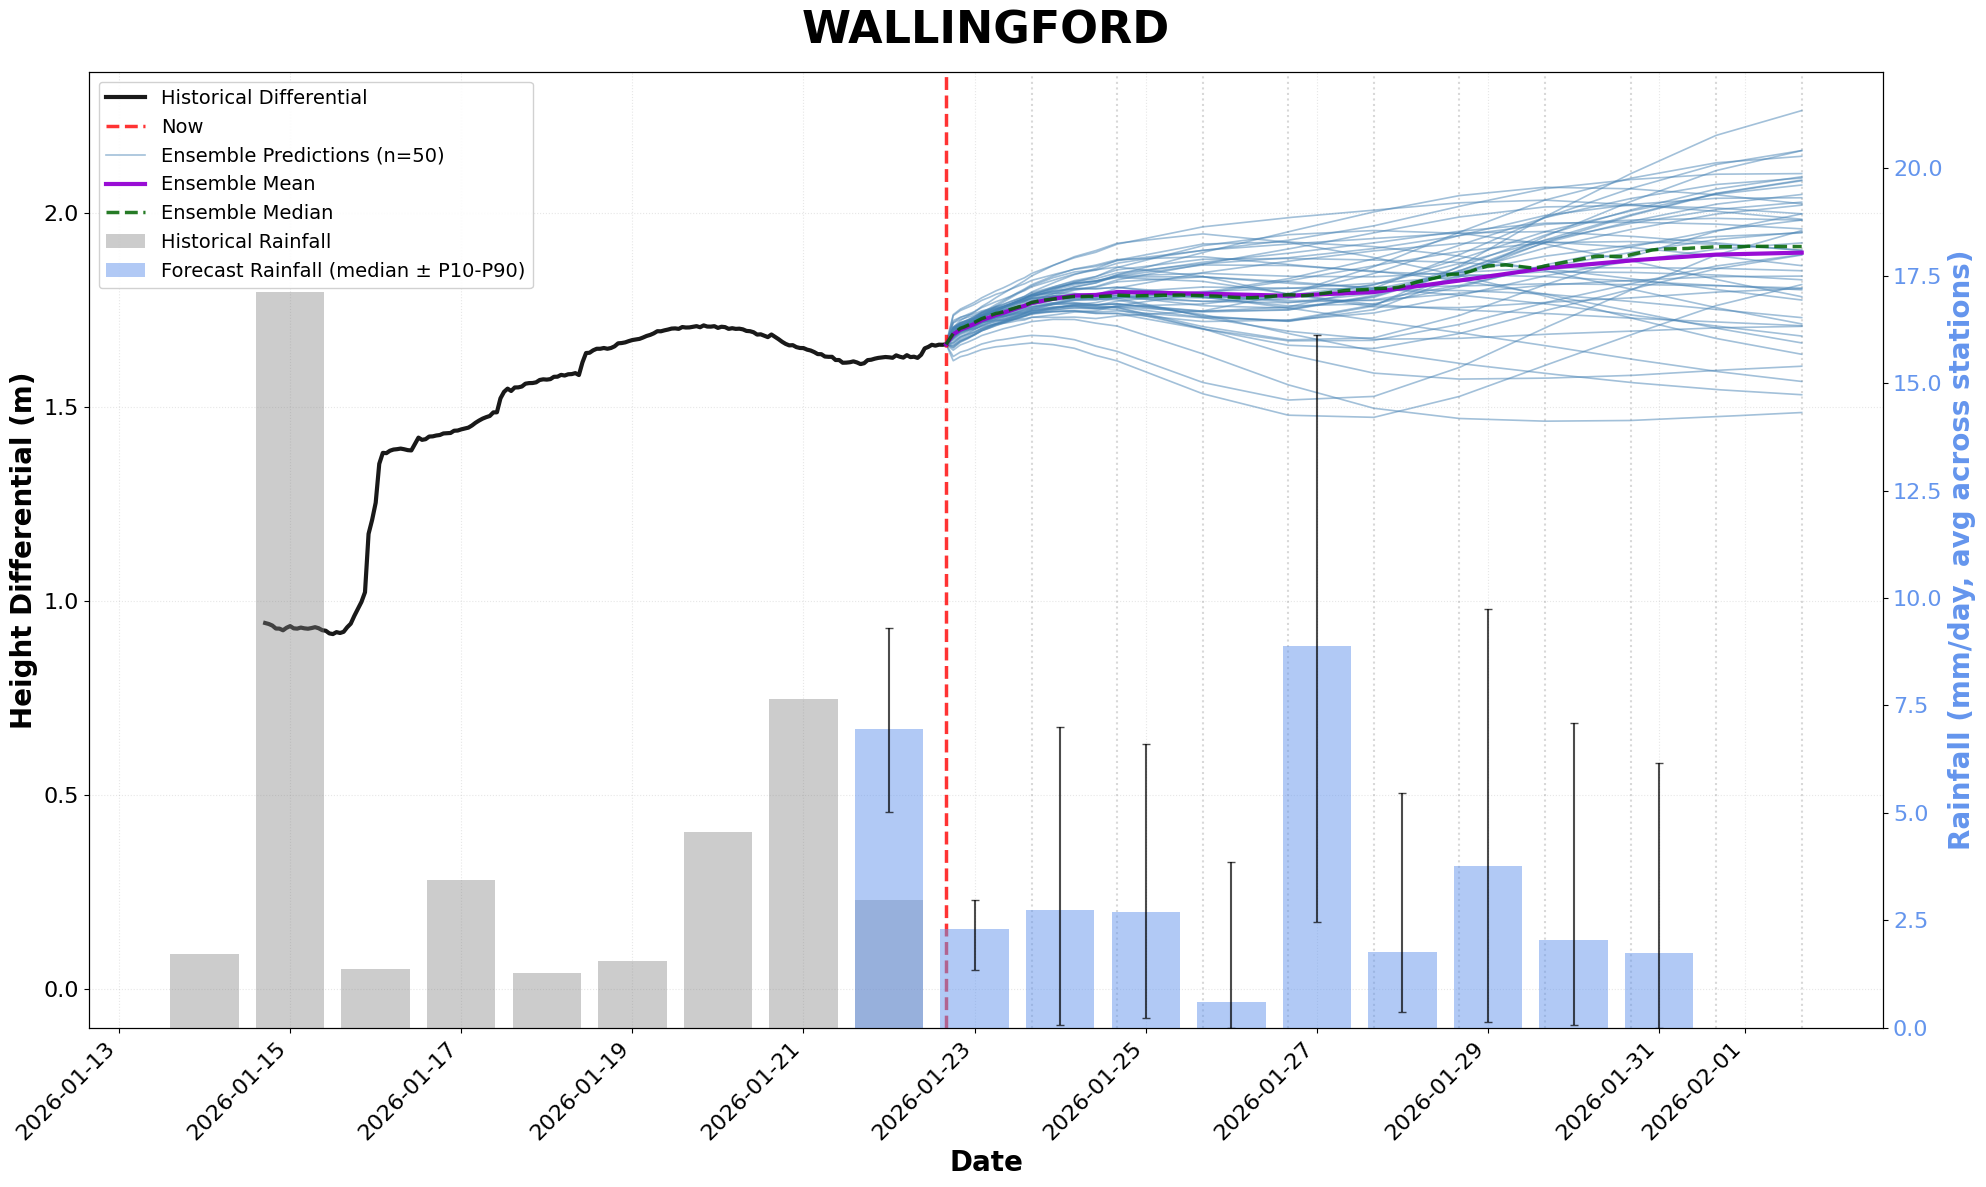


✓ Spaghetti plot with rainfall complete!
  River: 50 ensemble forecasts (blue lines) + mean (purple) + median (green dashed)
  Rainfall: Historical (gray bars) + Forecast with P10-P90 error bars (blue bars)
  Saved as 'spaghetti_with_rainfall.png'


In [38]:
# Spaghetti Plot with Rainfall Bars (same as original notebook)
print("\n" + "="*80)
print("STEP 7: Spaghetti Plot - All Ensemble Members with Rainfall")
print("="*80)

# Make data timezone-naive for plotting
plot_df = ensemble_predictions.copy()
if hasattr(plot_df.index, 'tz') and plot_df.index.tz is not None:
    plot_df.index = plot_df.index.tz_localize(None)

# Calculate ensemble statistics
plot_stats = pd.DataFrame({
    'mean': plot_df.mean(axis=1),
    'median': plot_df.median(axis=1),
    'std': plot_df.std(axis=1),
    'min': plot_df.min(axis=1),
    'max': plot_df.max(axis=1),
    'p05': plot_df.quantile(0.05, axis=1),
    'p10': plot_df.quantile(0.10, axis=1),
    'p25': plot_df.quantile(0.25, axis=1),
    'p75': plot_df.quantile(0.75, axis=1),
    'p90': plot_df.quantile(0.90, axis=1),
    'p95': plot_df.quantile(0.95, axis=1)
})

n_members_used = len(ensemble_predictions.columns)

# Create figure with dual y-axis
fig, ax = plt.subplots(figsize=(20, 12))
ax_rain = ax.twinx()  # Secondary axis for rainfall

# Add flag boundaries as horizontal filled regions (skip for Wallingford - white background)
if LOCATION.lower() != 'wallingford':
    ax.axhspan(-4, FLAG_THRESHOLDS['light_blue'][0], color=FLAG_COLORS['green'], alpha=0.08, zorder=0)
    ax.axhspan(FLAG_THRESHOLDS['light_blue'][0], FLAG_THRESHOLDS['dark_blue'][0], color=FLAG_COLORS['light_blue'], alpha=0.08, zorder=0)
    ax.axhspan(FLAG_THRESHOLDS['dark_blue'][0], FLAG_THRESHOLDS['amber'][0], color=FLAG_COLORS['dark_blue'], alpha=0.08, zorder=0)
    ax.axhspan(FLAG_THRESHOLDS['amber'][0], FLAG_THRESHOLDS['red'][0], color=FLAG_COLORS['amber'], alpha=0.08, zorder=0)
    ax.axhspan(FLAG_THRESHOLDS['red'][0], 4, color=FLAG_COLORS['red'], alpha=0.08, zorder=0)

# ============= RAINFALL DATA PREPARATION =============
print("Preparing rainfall data...")

# 1. Historical rainfall (last 8 days) - aggregate across all stations
hist_merged = merged_df.copy()
if hasattr(hist_merged.index, 'tz') and hist_merged.index.tz is not None:
    hist_merged.index = hist_merged.index.tz_localize(None)

last_8_days = hist_merged.iloc[-24*8:].copy()
# Get location-specific station names (excludes Bicester and Grimsbury for godstow, includes Wallingford-specific for wallingford)
station_names_list = get_location_station_names(LOCATION)
# Filter to only location-specific stations
rainfall_cols = [col for col in last_8_days.columns if col in station_names_list]
historical_rainfall_hourly = last_8_days[rainfall_cols].mean(axis=1)  # Average across stations
historical_rainfall_daily = historical_rainfall_hourly.resample('1D').sum()  # Daily totals

# 2. Forecast rainfall - calculate ensemble statistics
rainfall_forecast_naive = rainfall_forecast.copy()
if hasattr(rainfall_forecast_naive.index, 'tz') and rainfall_forecast_naive.index.tz is not None:
    rainfall_forecast_naive.index = rainfall_forecast_naive.index.tz_localize(None)

# For each timestamp, average across all stations for each member, then get statistics
# Use location-specific station names for rainfall calculations

# Calculate average rainfall per ensemble member (mean across all stations)
member_totals = pd.DataFrame(index=rainfall_forecast_naive.index)
for member_idx in range(n_members_used):
    member_cols = [f'{station}_member_{member_idx}' for station in station_names_list]
    existing_cols = [col for col in member_cols if col in rainfall_forecast_naive.columns]
    if existing_cols:
        member_totals[f'member_{member_idx}'] = rainfall_forecast_naive[existing_cols].mean(axis=1)

# Resample to daily for cleaner visualization
member_totals_daily = member_totals.resample('1D').sum()

# Calculate rainfall ensemble statistics
forecast_rain_median = member_totals_daily.median(axis=1)
forecast_rain_p10 = member_totals_daily.quantile(0.10, axis=1)
forecast_rain_p90 = member_totals_daily.quantile(0.90, axis=1)

# Error bars: distance from median to percentiles
error_lower = forecast_rain_median - forecast_rain_p10
error_upper = forecast_rain_p90 - forecast_rain_median

print(f"  Historical rainfall: {len(historical_rainfall_daily)} daily bars (avg across stations)")
print(f"  Forecast rainfall: {len(forecast_rain_median)} daily bars with ensemble spread (P10-P90)")

# ============= PLOT RAINFALL BARS =============
bar_width = 0.8  # Width in days

# Historical rainfall bars (gray)
ax_rain.bar(historical_rainfall_daily.index, historical_rainfall_daily.values,
           width=bar_width, color='gray', alpha=0.4, label='Historical Rainfall', zorder=1)

# Forecast rainfall bars with error bars showing ensemble spread
ax_rain.bar(forecast_rain_median.index, forecast_rain_median.values,
           width=bar_width, color='cornflowerblue', alpha=0.5,
           yerr=[error_lower.values, error_upper.values],
           error_kw={'elinewidth': 1.5, 'capsize': 3, 'capthick': 1, 'alpha': 0.7, 'color': 'navy'},
           label='Forecast Rainfall (median ± P10-P90)', zorder=2)

# ============= PLOT RIVER DIFFERENTIAL =============
# Determine forecast start time (where forecasts begin)
forecast_start_time = plot_df.index[0]

# Extend historical data to forecast start time if there's a gap
# This ensures the historical line connects seamlessly with forecasts
historical_to_plot = last_8_days.copy()
if historical_to_plot.index[-1] < forecast_start_time:
    # Fill gap by forward-filling the last known value
    gap_times = pd.date_range(
        start=historical_to_plot.index[-1] + pd.Timedelta(hours=1),
        end=forecast_start_time,
        freq='1h'
    )
    gap_data = pd.Series(
        [historical_to_plot['differential'].iloc[-1]] * len(gap_times),
        index=gap_times
    )
    historical_to_plot = pd.concat([
        historical_to_plot,
        pd.DataFrame({'differential': gap_data})
    ])
elif historical_to_plot.index[-1] > forecast_start_time:
    # Trim historical data to end at forecast start
    historical_to_plot = historical_to_plot[historical_to_plot.index <= forecast_start_time]

# Plot historical differential as a solid black line
ax.plot(historical_to_plot.index, historical_to_plot['differential'].values, 
        color='black', linewidth=3, label='Historical Differential', zorder=100, alpha=0.9)

# Current time marker (where forecasts start)
current_time = forecast_start_time
ax.axvline(x=current_time, color='red', linestyle='--', linewidth=2.5, 
          alpha=0.8, label='Now', zorder=101)

# Plot ALL ensemble member river forecasts (spaghetti plot)
print(f"Plotting {n_members_used} ensemble member trajectories...")

for idx, col in enumerate(plot_df.columns):
    if idx == 0:
        ax.plot(plot_df.index, plot_df[col].values, 
                color='steelblue', linewidth=1.2, alpha=0.5, 
                label=f'Ensemble Predictions (n={n_members_used})', zorder=50)
    else:
        ax.plot(plot_df.index, plot_df[col].values, 
                color='steelblue', linewidth=1.2, alpha=0.5, zorder=50)

# Overlay the ensemble MEAN as a bold line
ax.plot(plot_df.index, plot_stats['mean'].values, 
       color='darkviolet', linewidth=3, 
       label='Ensemble Mean', zorder=102, alpha=0.95)

# Also plot the ensemble MEDIAN
ax.plot(plot_df.index, plot_stats['median'].values, 
       color='darkgreen', linewidth=2.5, linestyle='--',
       label='Ensemble Median', zorder=103, alpha=0.85)

# ============= FORMATTING =============
ax.set_xlabel('Date', fontsize=20, fontweight='bold')
ax.set_ylabel('Height Differential (m)', fontsize=20, fontweight='bold', color='black')
ax_rain.set_ylabel('Rainfall (mm/day, avg across stations)', fontsize=20, fontweight='bold', color='cornflowerblue')

ax.tick_params(axis='both', labelsize=16, labelcolor='black')
ax_rain.tick_params(axis='y', labelsize=16, labelcolor='cornflowerblue')

# Set y-limits
ax.set_ylim(-0.1, max(1.1, plot_stats['max'].max() + 0.1))
max_rain = max(historical_rainfall_daily.max(), forecast_rain_p90.max()) if len(forecast_rain_p90) > 0 else historical_rainfall_daily.max()
ax_rain.set_ylim(0, max_rain * 1.3)

ax.set_title(f'{LOCATION.upper()}', 
            fontsize=32, fontweight='bold', pad=20)

ax.grid(True, alpha=0.3, linestyle=':', linewidth=0.8)

# Combined legend
lines1, labels1 = ax.get_legend_handles_labels()
lines2, labels2 = ax_rain.get_legend_handles_labels()
ax.legend(lines1 + lines2, labels1 + labels2, fontsize=14, loc='upper left', framealpha=0.9)

# Add day markers
for i in range(1, 11):
    day_time = current_time + pd.Timedelta(days=i)
    if day_time <= plot_df.index[-1]:
        ax.axvline(x=day_time, color='gray', linestyle=':', alpha=0.3, zorder=0)

plt.setp(ax.xaxis.get_majorticklabels(), rotation=45, ha='right')
plt.tight_layout()
plt.savefig('../spaghetti_with_rainfall.png', dpi=150, bbox_inches='tight')
plt.show()

print("\n✓ Spaghetti plot with rainfall complete!")
print(f"  River: {n_members_used} ensemble forecasts (blue lines) + mean (purple) + median (green dashed)")
print(f"  Rainfall: Historical (gray bars) + Forecast with P10-P90 error bars (blue bars)")
print(f"  Saved as 'spaghetti_with_rainfall.png'")

## Visualization: Flag Probabilities

In [43]:
# Calculate flag probabilities using the 5-flag system (same as original notebook)
def calculate_flag_probabilities(ensemble_df, thresholds):
    """Calculate probability of each flag color at each timestep."""
    n_members = ensemble_df.shape[1]
    probs_df = pd.DataFrame(index=ensemble_df.index)
    
    for flag, (lower, upper) in thresholds.items():
        count = ((ensemble_df >= lower) & (ensemble_df < upper)).sum(axis=1)
        probs_df[f'p_{flag}'] = count / n_members
    
    return probs_df

# Skip flag probabilities for Wallingford (white flags - no flags)
if LOCATION.lower() != 'wallingford':
    flag_probabilities = calculate_flag_probabilities(plot_df, FLAG_THRESHOLDS)
    
    print(f"✓ Flag probabilities calculated for {len(flag_probabilities)} timesteps")
    
    # Show flag probabilities at key horizons
    print("\n" + "="*70)
    print("FLAG PROBABILITIES AT KEY HORIZONS")
    print("="*70)
    print(f"{'Hour':<8} {'Green':>8} {'Lt Blue':>10} {'Dk Blue':>10} {'Amber':>8} {'Red':>8}")
    print("-"*70)
    
    for hours_ahead in [0, 6, 12, 24, 48, 72, 120, 168, 240]:
        if hours_ahead < len(flag_probabilities):
            row = flag_probabilities.iloc[hours_ahead]
            print(f"{hours_ahead:<8} {row['p_green']*100:>7.1f}% {row['p_light_blue']*100:>9.1f}% "
                  f"{row['p_dark_blue']*100:>9.1f}% {row['p_amber']*100:>7.1f}% {row['p_red']*100:>7.1f}%")
    
    # Create stacked area plot for flag probabilities
    fig, ax = plt.subplots(figsize=(18, 6))
    
    ax.stackplot(
        flag_probabilities.index,
        [flag_probabilities['p_green'], flag_probabilities['p_light_blue'], 
         flag_probabilities['p_dark_blue'], flag_probabilities['p_amber'], flag_probabilities['p_red']],
        labels=['Green', 'Light Blue', 'Dark Blue', 'Amber', 'Red'],
        colors=[FLAG_COLORS['green'], FLAG_COLORS['light_blue'], FLAG_COLORS['dark_blue'], 
                FLAG_COLORS['amber'], FLAG_COLORS['red']],
        alpha=0.8
    )
    
    ax.set_xlabel('Date/Time', fontsize=12)
    ax.set_ylabel('Probability', fontsize=12)
    ax.set_title(f'{config.display_name} - Flag Probability Forecast', fontsize=14, fontweight='bold')
    ax.legend(loc='upper right', fontsize=10)
    ax.set_ylim(0, 1)
    ax.grid(True, alpha=0.3)
    
    # Add vertical lines for day markers
    for i in range(1, 11):
        day_time = flag_probabilities.index[0] + pd.Timedelta(hours=24*i)
        if day_time <= flag_probabilities.index[-1]:
            ax.axvline(x=day_time, color='gray', linestyle='--', alpha=0.3)
    
    plt.tight_layout()
    plt.savefig('../flag_probabilities.png', dpi=150, bbox_inches='tight')
    plt.show()
    
    print("\n✓ Plot saved as 'flag_probabilities.png'")
else:
    # For Wallingford, create empty flag_probabilities DataFrame to avoid errors
    flag_probabilities = pd.DataFrame(index=plot_df.index)
    flag_probabilities['p_green'] = 0
    flag_probabilities['p_light_blue'] = 0
    flag_probabilities['p_dark_blue'] = 0
    flag_probabilities['p_amber'] = 0
    flag_probabilities['p_red'] = 0
    print("✓ Skipping flag probabilities for Wallingford (white flags - no flags)")

✓ Skipping flag probabilities for Wallingford (white flags - no flags)


## Forecast Summary

In [44]:
# Print summary (same format as original notebook)
def get_flag_from_diff(diff, thresholds):
    """Get flag color from differential value."""
    if diff >= thresholds['red'][0]:
        return 'RED'
    elif diff >= thresholds['amber'][0]:
        return 'AMBER'
    elif diff >= thresholds['dark_blue'][0]:
        return 'DARK BLUE'
    elif diff >= thresholds['light_blue'][0]:
        return 'LIGHT BLUE'
    else:
        return 'GREEN'

print(f"\n{'='*70}")
print(f"FORECAST SUMMARY - {config.display_name}")
print(f"{'='*70}")

# Current conditions
current_diff = merged_df['differential'].iloc[-1]
if LOCATION.lower() != 'wallingford':
    current_flag = get_flag_from_diff(current_diff, FLAG_THRESHOLDS)
    print(f"\nCurrent differential: {current_diff:.3f}m ({current_flag} flag)")
else:
    print(f"\nCurrent differential: {current_diff:.3f}m (white flag - no flag)")

# Forecast at key horizons
key_horizons = [24, 48, 72, 120, 168, 240]
print(f"\nForecast at key horizons:")
if LOCATION.lower() != 'wallingford':
    print(f"{'Horizon':>10} {'Mean':>10} {'Range (5-95%)':>20} {'Most likely flag':>18}")
else:
    print(f"{'Horizon':>10} {'Mean':>10} {'Range (5-95%)':>20}")
print("-" * 70)

for h in key_horizons:
    try:
        # Find the timestamp that is h hours from forecast start
        # Use plot_df.index[0] as the forecast start time
        target_time = plot_df.index[0] + pd.Timedelta(hours=h)
        
        # Check if target_time exists in the DataFrames
        if target_time in plot_stats.index and target_time in flag_probabilities.index:
            mean_val = plot_stats.loc[target_time, 'mean']
            p05 = plot_stats.loc[target_time, 'p05']
            p95 = plot_stats.loc[target_time, 'p95']
            
            if LOCATION.lower() != 'wallingford':
                # Most likely flag
                row = flag_probabilities.loc[target_time]
                probs = {k.replace('p_', ''): v for k, v in row.items()}
                most_likely = max(probs, key=probs.get).upper().replace('_', ' ')
                print(f"{h:>7}h    {mean_val:>8.3f}m    {p05:.3f}m - {p95:.3f}m    {most_likely:>18}")
            else:
                # Skip flag for Wallingford
                print(f"{h:>7}h    {mean_val:>8.3f}m    {p05:.3f}m - {p95:.3f}m")
    except (KeyError, IndexError) as e:
        # Skip if timestamp not found or other error
        pass

print(f"\n{'='*70}")


FORECAST SUMMARY - Wallingford Stretch

Current differential: 1.662m (RED flag)

Forecast at key horizons:
   Horizon       Mean        Range (5-95%)   Most likely flag
----------------------------------------------------------------------
     24h       1.768m    1.725m - 1.822m                 GREEN
     48h       1.797m    1.720m - 1.879m                 GREEN
     72h       1.792m    1.666m - 1.918m                 GREEN
    120h       1.796m    1.554m - 1.962m                 GREEN
    168h       1.858m    1.596m - 2.033m                 GREEN
    240h       1.898m    1.584m - 2.154m                 GREEN



## Historical Data Plot (Last 30 Days)

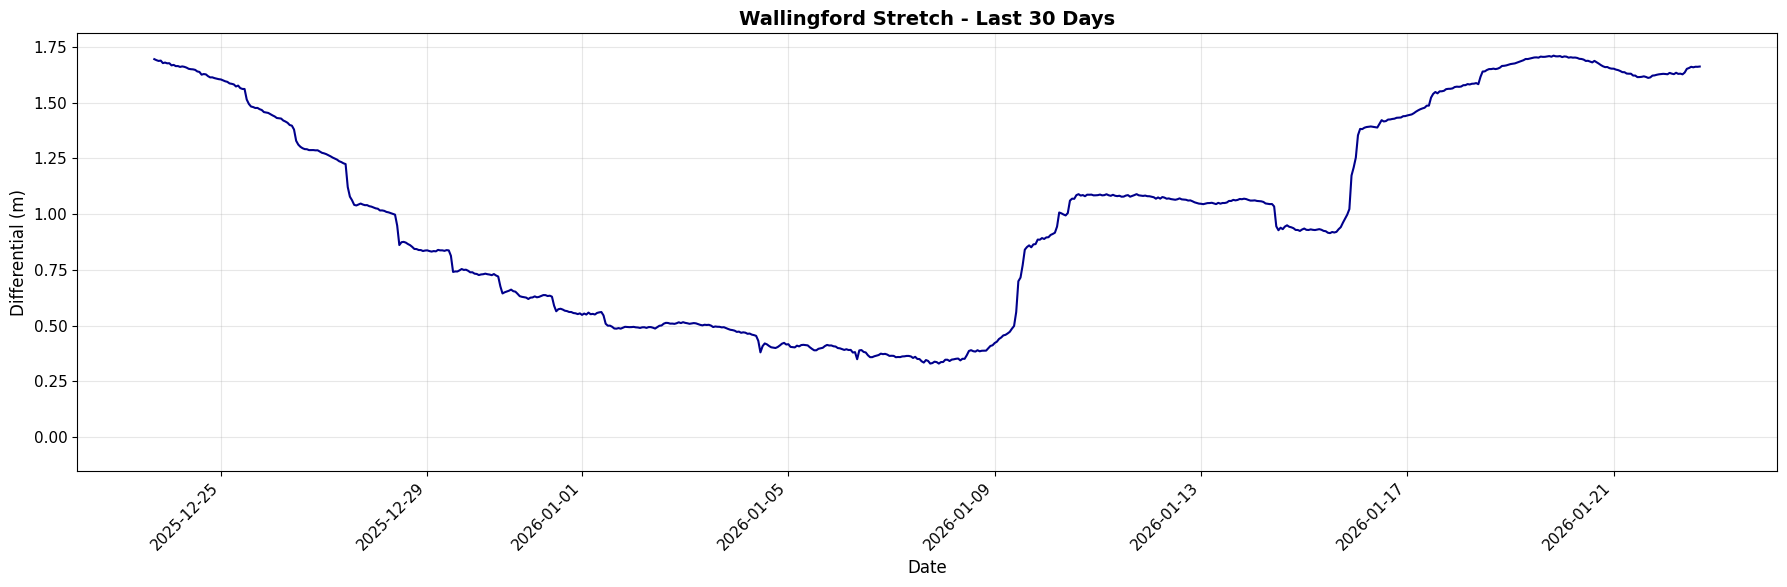

In [47]:
# Plot last 30 days of historical data (same style as original notebook)
fig, ax = plt.subplots(figsize=(18, 6))

last_30_days = merged_df['differential'].last('30D')

# Add flag color background bands (skip for Wallingford - white background)
if LOCATION.lower() != 'wallingford':
    ax.axhspan(-2, FLAG_THRESHOLDS['light_blue'][0], color=FLAG_COLORS['green'], alpha=0.15)
    ax.axhspan(FLAG_THRESHOLDS['light_blue'][0], FLAG_THRESHOLDS['dark_blue'][0], color=FLAG_COLORS['light_blue'], alpha=0.15)
    ax.axhspan(FLAG_THRESHOLDS['dark_blue'][0], FLAG_THRESHOLDS['amber'][0], color=FLAG_COLORS['dark_blue'], alpha=0.15)
    ax.axhspan(FLAG_THRESHOLDS['amber'][0], FLAG_THRESHOLDS['red'][0], color=FLAG_COLORS['amber'], alpha=0.15)
    ax.axhspan(FLAG_THRESHOLDS['red'][0], 3, color=FLAG_COLORS['red'], alpha=0.15)

ax.plot(last_30_days.index, last_30_days.values, color='darkblue', linewidth=1.5)

ax.set_xlabel('Date', fontsize=12)
ax.set_ylabel('Differential (m)', fontsize=12)
ax.set_title(f'{config.display_name} - Last 30 Days', fontsize=14, fontweight='bold')
ax.grid(True, alpha=0.3)

# Set y limits
y_min = min(last_30_days.min(), -0.1)
y_max = max(last_30_days.max(), 0.6)
ax.set_ylim(y_min - 0.05, y_max + 0.1)

plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

## Historical Validation: What-If Forecast

Test the model by making a forecast from a historical date and comparing it against what actually happened.
This validates that the ensemble predictions are working correctly.


HISTORICAL VALIDATION - What-If Forecasts for 2025-02
Found 28 valid dates to validate
Date range: 2025-02-01 08:00:00 to 2025-02-28 08:00:00

Processing 2025-02-01 08:00... ✓ Generated 241 hour forecast

Processing 2025-02-02 08:00... ✓ Generated 241 hour forecast

Processing 2025-02-03 08:00... ✓ Generated 241 hour forecast

Processing 2025-02-04 08:00... ✓ Generated 241 hour forecast

Processing 2025-02-05 08:00... ✓ Generated 241 hour forecast

Processing 2025-02-06 08:00... ✓ Generated 241 hour forecast

Processing 2025-02-07 08:00... ✓ Generated 241 hour forecast

Processing 2025-02-08 08:00... ✓ Generated 241 hour forecast

Processing 2025-02-09 08:00... ✓ Generated 241 hour forecast

Processing 2025-02-10 08:00... ✓ Generated 241 hour forecast

Processing 2025-02-11 08:00... ✓ Generated 241 hour forecast

Processing 2025-02-12 08:00... ✓ Generated 241 hour forecast

Processing 2025-02-13 08:00... ✓ Generated 241 hour forecast

Processing 2025-02-14 08:00... ✓ Generated 241 hou

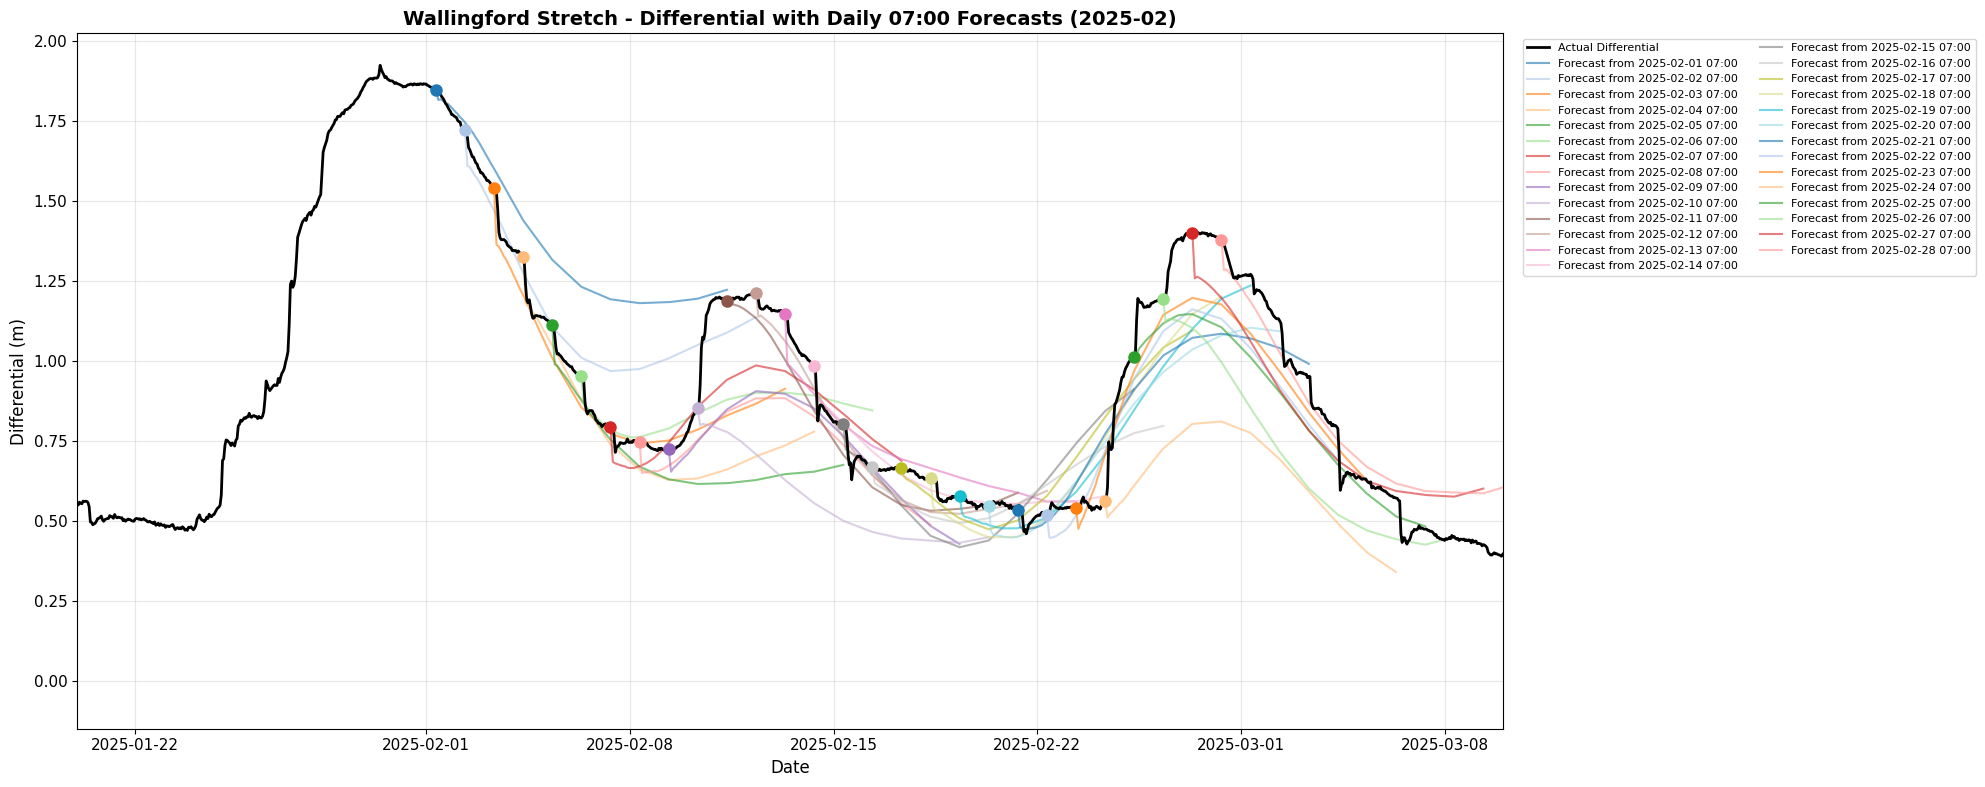


✓ Full validation plot saved as '../validation_202502_full.png'
✓ Generated 28 forecasts for 2025-02


In [48]:
# Historical Validation - What-If Forecast for any month/year
# Run validation for 07:00 every day in the specified month, showing full context

import warnings
warnings.filterwarnings('ignore')

from flag_predictor.prediction import predict_single
from flag_predictor.processing.features import create_features_with_future_rainfall

# Specify the month to validate
VALIDATION_YEAR = 2025
VALIDATION_MONTH =2

print(f"\n{'='*70}")
print(f"HISTORICAL VALIDATION - What-If Forecasts for {VALIDATION_YEAR}-{VALIDATION_MONTH:02d}")
print(f"{'='*70}")

# Make merged_df timezone-naive for this operation
validation_merged = merged_df.copy()
if hasattr(validation_merged.index, 'tz') and validation_merged.index.tz is not None:
    tz = validation_merged.index.tz
    validation_merged.index = validation_merged.index.tz_localize(None)
else:
    tz = None

# Generate all dates at 07:00 for the specified month
start_date = pd.Timestamp(year=VALIDATION_YEAR, month=VALIDATION_MONTH, day=1, hour=8)

# Calculate end date (first day of next month)
if VALIDATION_MONTH == 12:
    end_date = pd.Timestamp(year=VALIDATION_YEAR + 1, month=1, day=1, hour=8)
else:
    end_date = pd.Timestamp(year=VALIDATION_YEAR, month=VALIDATION_MONTH + 1, day=1, hour=8)

validation_dates = pd.date_range(start=start_date, end=end_date, freq='D', inclusive='left')

# Filter dates that are within valid range
min_valid_date = validation_merged.index.min() + pd.Timedelta(hours=720)
max_valid_date = validation_merged.index.max() - pd.Timedelta(hours=240)
valid_dates = [d for d in validation_dates if min_valid_date <= d <= max_valid_date]

print(f"Found {len(valid_dates)} valid dates to validate")
if len(valid_dates) > 0:
    print(f"Date range: {valid_dates[0]} to {valid_dates[-1]}")

# Store all forecasts for plotting
all_forecasts = {}

for forecast_time in valid_dates:
    try:
        print(f"\nProcessing {forecast_time.strftime('%Y-%m-%d %H:%M')}...", end=' ')
        
        # Get historical data up to forecast time
        historical_until_t0 = validation_merged[validation_merged.index <= forecast_time].copy()
        
        # Get ACTUAL future data to use as "perfect" rainfall forecast
        window_end = forecast_time + pd.Timedelta(hours=240)
        actual_future = validation_merged[(validation_merged.index > forecast_time) & 
                                           (validation_merged.index <= window_end)].copy()
        
        # Create rainfall forecast from actual data
        # Use location-specific station names (excludes Bicester and Grimsbury for godstow, includes Wallingford-specific for wallingford)
        station_names_list = get_location_station_names(LOCATION)
        rainfall_cols = [col for col in actual_future.columns if col in station_names_list]
        actual_future_rainfall = actual_future[rainfall_cols].copy()
        
        # Run prediction
        clairvoyant_pred = predict_single(
            model=model,
            scaler=scaler,
            historical_df=historical_until_t0,
            rainfall_forecast_df=actual_future_rainfall,
            feature_columns=model_config['feature_columns'],
            sequence_length=model_config['sequence_length'],
            horizons=model_config['horizons'],
            verbose=False
        )
        
        # Make prediction timezone-naive if needed
        if hasattr(clairvoyant_pred.index, 'tz') and clairvoyant_pred.index.tz is not None:
            clairvoyant_pred.index = clairvoyant_pred.index.tz_localize(None)
        
        # Store forecast
        all_forecasts[forecast_time] = clairvoyant_pred
        
        print(f"✓ Generated {len(clairvoyant_pred)} hour forecast")
            
    except Exception as e:
        print(f"✗ Error: {e}")

# Create comprehensive visualization
if len(all_forecasts) > 0:
    # Define plotting period: one month before to one month after validation month
    if VALIDATION_MONTH == 1:
        plot_start = pd.Timestamp(year=VALIDATION_YEAR - 1, month=12, day=20)
    else:
        plot_start = pd.Timestamp(year=VALIDATION_YEAR, month=VALIDATION_MONTH - 1, day=20)
    
    if VALIDATION_MONTH == 12:
        plot_end = pd.Timestamp(year=VALIDATION_YEAR + 1, month=1, day=10)
    else:
        plot_end = pd.Timestamp(year=VALIDATION_YEAR, month=VALIDATION_MONTH + 1, day=10)
    
        # Get rainfall data for the full period
    # Use location-specific station names (excludes Bicester and Grimsbury for godstow, includes Wallingford-specific for wallingford)
    station_names_list = get_location_station_names(LOCATION)
    rainfall_cols = [col for col in validation_merged.columns if col in station_names_list]
    rainfall_data = validation_merged[rainfall_cols].loc[plot_start:plot_end]
    
    # Get actual differential for the full period
    actual_diff = validation_merged['differential'].loc[plot_start:plot_end]
    
    # Create figure with single subplot
    fig = plt.figure(figsize=(20, 8))
    ax = fig.add_subplot(111)
    
    # Add flag color background bands (skip for Wallingford - white background)
    if LOCATION.lower() != 'wallingford':
        ax.axhspan(-2, FLAG_THRESHOLDS['light_blue'][0], color=FLAG_COLORS['green'], alpha=0.15)
        ax.axhspan(FLAG_THRESHOLDS['light_blue'][0], FLAG_THRESHOLDS['dark_blue'][0], 
                    color=FLAG_COLORS['light_blue'], alpha=0.15)
        ax.axhspan(FLAG_THRESHOLDS['dark_blue'][0], FLAG_THRESHOLDS['amber'][0], 
                    color=FLAG_COLORS['dark_blue'], alpha=0.15)
        ax.axhspan(FLAG_THRESHOLDS['amber'][0], FLAG_THRESHOLDS['red'][0], 
                    color=FLAG_COLORS['amber'], alpha=0.15)
        ax.axhspan(FLAG_THRESHOLDS['red'][0], 3, color=FLAG_COLORS['red'], alpha=0.15)
    
    # Plot actual differential
    ax.plot(actual_diff.index, actual_diff.values, 
             color='black', linewidth=2, label='Actual Differential', zorder=10)
    
    # Plot all forecasts starting at 07:00 each day
    for i, (forecast_time, forecast) in enumerate(all_forecasts.items()):
        # Use different colors for different days
        color = plt.cm.tab20(i % 20)
        
        # Get the actual differential at forecast_time to anchor the forecast
        if forecast_time in actual_diff.index:
            current_actual = actual_diff.loc[forecast_time]
            
            # Prepend the actual value at forecast_time to the forecast
            # so the line starts exactly on the black line
            anchored_forecast = pd.Series(
                [current_actual] + forecast.values.tolist(),
                index=[forecast_time] + forecast.index.tolist()
            )
        else:
            # Fallback: use forecast as-is if forecast_time not in actual_diff
            anchored_forecast = forecast
        
        ax.plot(anchored_forecast.index, anchored_forecast.values, 
                color=color, linewidth=1.5, alpha=0.6,
                label=f'Forecast from {forecast_time.strftime("%Y-%m-%d 07:00")}')
        
        # Mark the forecast start time
        if forecast_time in actual_diff.index:
            ax.plot(forecast_time, actual_diff.loc[forecast_time], 
                    'o', color=color, markersize=8, zorder=11)
    
    ax.set_xlabel('Date', fontsize=12)
    ax.set_ylabel('Differential (m)', fontsize=12)
    ax.set_title(f'{config.display_name} - Differential with Daily 07:00 Forecasts ({VALIDATION_YEAR}-{VALIDATION_MONTH:02d})', 
                  fontsize=14, fontweight='bold')
    ax.legend(loc='upper left', fontsize=8, ncol=2, bbox_to_anchor=(1.01, 1))
    ax.grid(True, alpha=0.3)
    ax.set_xlim(plot_start, plot_end)
    
    # Set y limits for differential plot
    y_min = min(actual_diff.min(), -0.1)
    y_max = max(actual_diff.max(), 0.6)
    ax.set_ylim(y_min - 0.05, y_max + 0.1)
    
    plt.tight_layout()
    
    # Generate filename with year and month
    filename = f'../validation_{VALIDATION_YEAR}{VALIDATION_MONTH:02d}_full.png'
    plt.savefig(filename, dpi=150, bbox_inches='tight')
    plt.show()
    
    print(f"\n✓ Full validation plot saved as '{filename}'")
    print(f"✓ Generated {len(all_forecasts)} forecasts for {VALIDATION_YEAR}-{VALIDATION_MONTH:02d}")
else:
    print(f"\n⚠ No valid forecasts could be generated for {VALIDATION_YEAR}-{VALIDATION_MONTH:02d}")